In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx
import random

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [5]:
dists, dat, _, keys = load(zscore_filter=False)

In [7]:
networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

In [11]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, verbose=False)

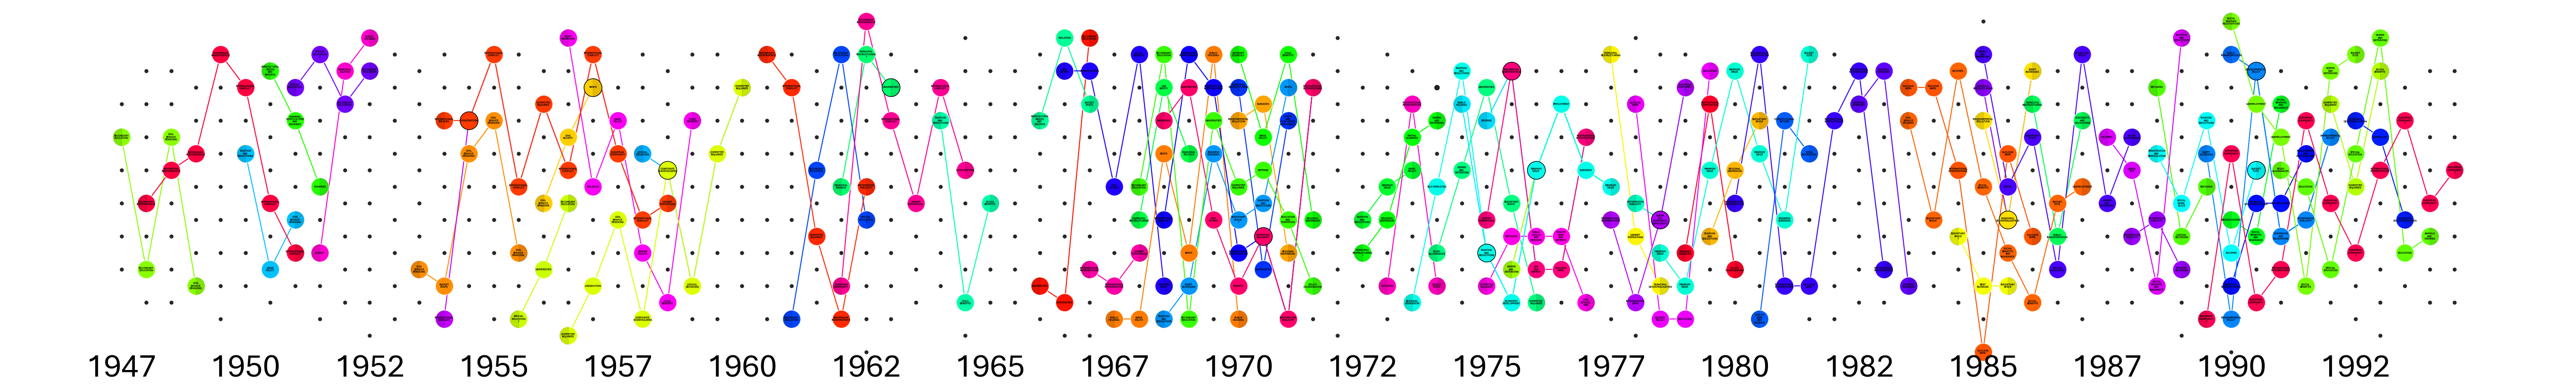

In [13]:
plot_flows(g, tc, paths, networks, sizes, cmap='hsv',figsize=(70,10))

## Chain Stats

In [16]:
path_topics = {i:pd.DataFrame([item for items in p for item in tc.get_community(items)],columns=['topic']).value_counts() for i,p in enumerate(paths)}
pdf = pd.DataFrame({i:p.max() for i,p in path_topics.items()}.items(),columns=['path_id','max']).sort_values('max',ascending=False)
pdf['topics'] = pdf.path_id.apply(lambda i:', '.join(path_topics[i].reset_index().topic[:4]))
pdf['len'] = pdf.path_id.apply(lambda i: len(paths[i]))
pdf['max_topic_persistence'] = pdf['max'] / pdf['len']
pdf['mean_topic_persistence'] = pdf.path_id.apply(lambda i:np.mean(path_topics[i] / pdf['len'][i]))
pdf[pdf['len'] > 8].sort_values('mean_topic_persistence',ascending=False)

,path_id,max,topics,len,max_topic_persistence,mean_topic_persistence
35,35,9,"inflation, employment, minimum wage, budget cuts",9,1.0,0.342857
63,63,11,"european community, international intervention...",11,1.0,0.337662
7,7,10,"foreign relations, european community, interna...",10,1.0,0.325926
8,8,9,"foreign relations, european community, interna...",10,0.9,0.314815
